**ĐỒ ÁN CUỐI KÌ CS116**

GVHD: Nguyễn Vĩnh Tiệp

Nhóm sinh viên:
- Võ Nhật Thanh
- Lê Vinh Quang
- Trần Trung Tín
- Hồ Thịnh 

#Cài đặt thư viện, Dataset

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score,mean_absolute_percentage_error

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train_data_path = '/content/drive/MyDrive/CS116/CS116_FinalReport/train.csv'
val_data_path = '/content/drive/MyDrive/CS116/CS116_FinalReport/test.csv'
train_df = pd.read_csv(train_data_path, index_col='Id')
val_df = pd.read_csv(val_data_path, index_col='Id')

In [4]:
train_df.head(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
val_df.head(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


#Tiền xử lý dữ liệu

In [6]:
def pre_process(df):
    #loại bỏ các cột có giá trị không xác định
    df=df.drop(['MiscFeature','PoolQC','Fence','Alley'],axis=1)

    #chọn các cột chứa các dữ liệu số
    num_df=df.select_dtypes(include='number')
    num_cols=num_df.columns
    #xử lý các cột dữ liệu số
    for col in num_cols:
        df[col]=df[col].fillna(df[col].median())
    
    #xử lý các cột dữ liệu string
    str_df=df.select_dtypes(include='object')
    str_cols=str_df.columns
    for col in str_cols:
        df[col]=df[col].fillna(df['LotShape'].value_counts().idxmax())
    
    #factorize các cột dữ liệu string
    for col in str_cols:
        df[col]=pd.factorize(df[col])[0]  

    return df

In [7]:
train_data = pre_process(train_df)
val_data = pre_process(val_df)

In [8]:
train_data.head(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,0,65.0,8450,0,0,0,0,0,0,...,0,0,0,0,0,2,2008,0,0,208500
2,20,0,80.0,9600,0,0,0,0,1,0,...,0,0,0,0,0,5,2007,0,0,181500
3,60,0,68.0,11250,0,1,0,0,0,0,...,0,0,0,0,0,9,2008,0,0,223500
4,70,0,60.0,9550,0,1,0,0,2,0,...,272,0,0,0,0,2,2006,0,1,140000
5,60,0,84.0,14260,0,1,0,0,1,0,...,0,0,0,0,0,12,2008,0,0,250000


In [9]:
val_data.head(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,0,80.0,11622,0,0,0,0,0,0,...,0,0,0,120,0,0,6,2010,0,0
1462,20,1,81.0,14267,0,1,0,0,1,0,...,36,0,0,0,0,12500,6,2010,0,0
1463,60,1,74.0,13830,0,1,0,0,0,0,...,34,0,0,0,0,0,3,2010,0,0
1464,60,1,78.0,9978,0,1,0,0,0,0,...,36,0,0,0,0,0,6,2010,0,0
1465,120,1,43.0,5005,0,1,1,0,0,0,...,82,0,0,144,0,0,1,2010,0,0


#Phân tích dữ liệu

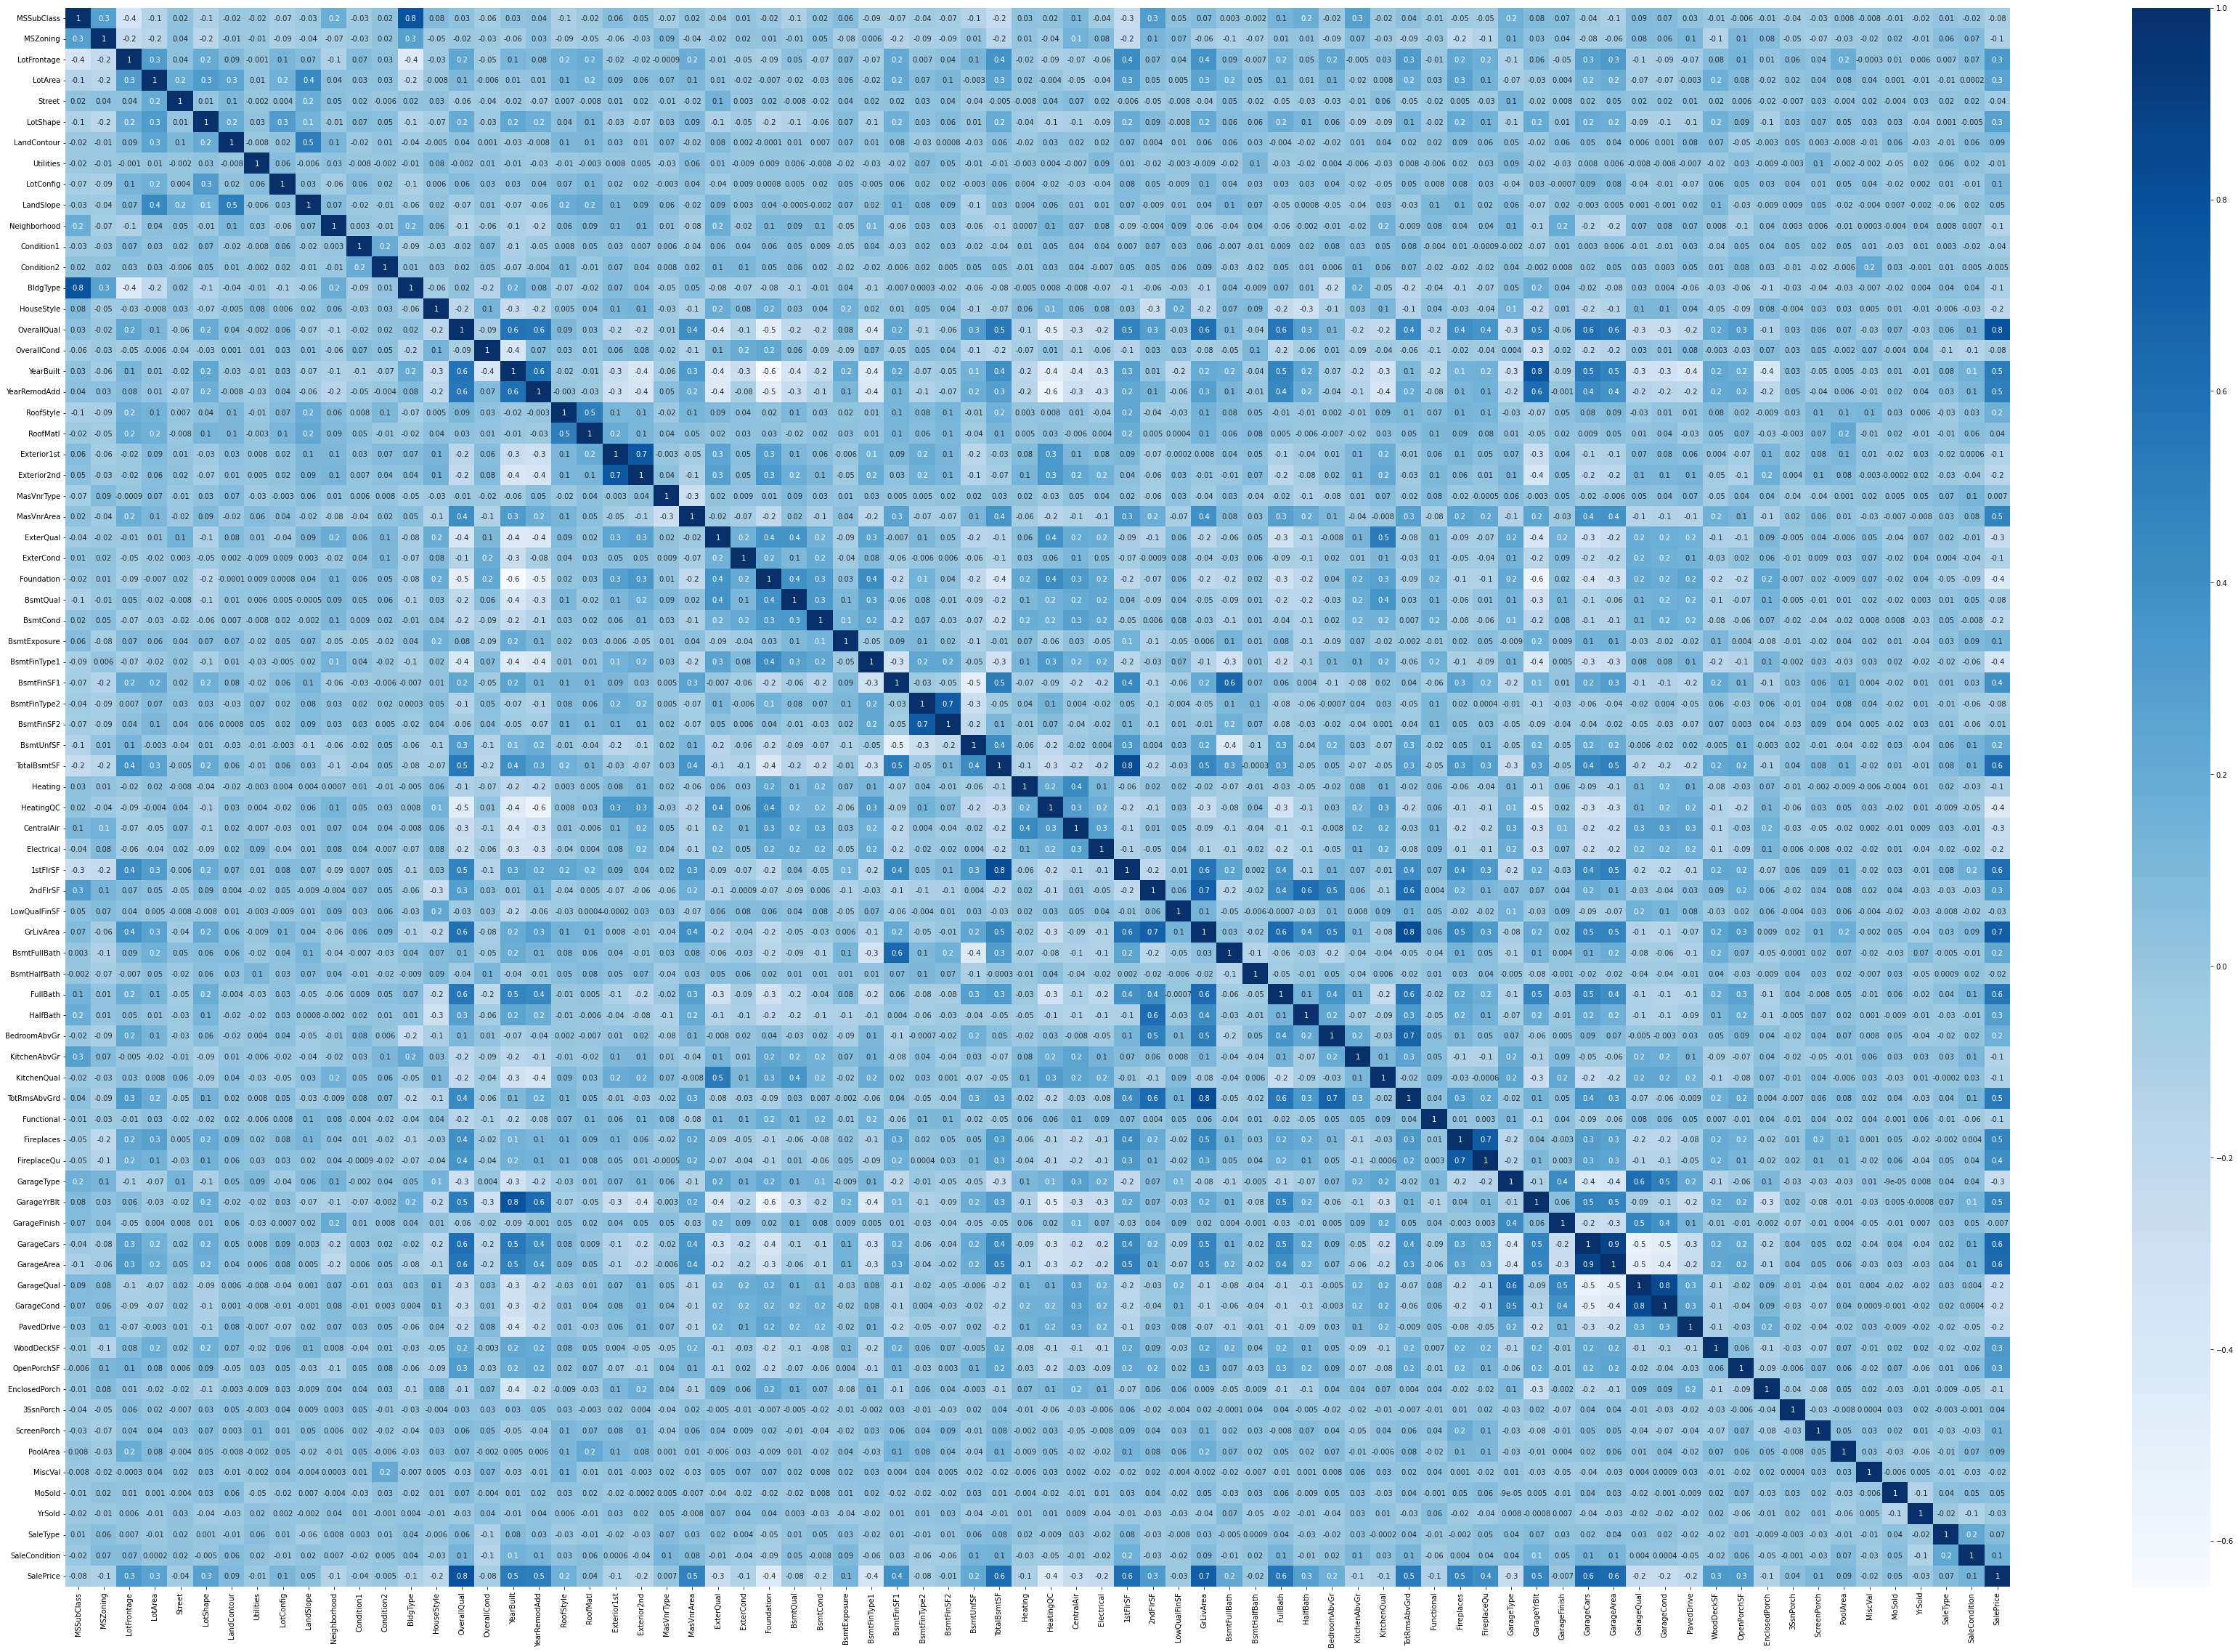

In [11]:
#EDA on training data
cor=train_data.corr()
plt.figure(figsize=(60,40))
sns.heatmap(data=cor,annot=True,cmap='Blues',fmt='.1g')
plt.show()

In [12]:
#Lấy các cột có độ tương quan cao với cột SalePrice (>=0.5)
eda_cols=['OverallQual','YearBuilt','YearRemodAdd','MasVnrArea','TotalBsmtSF','1stFlrSF','GrLivArea','FullBath','TotRmsAbvGrd','Fireplaces','GarageYrBlt','GarageCars','GarageArea','SalePrice']
eda_train_data=train_data[eda_cols]
eda_train_data.head(5)

,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,SalePrice
Id,,,,,,,,,,,,,,
1,7,2003,2003,196.0,856,856,1710,2,8,0,2003.0,2,548,208500
2,6,1976,1976,0.0,1262,1262,1262,2,6,1,1976.0,2,460,181500
3,7,2001,2002,162.0,920,920,1786,2,6,1,2001.0,2,608,223500
4,7,1915,1970,0.0,756,961,1717,1,7,1,1998.0,3,642,140000
5,8,2000,2000,350.0,1145,1145,2198,2,9,1,2000.0,3,836,250000


<Figure size 1440x1080 with 0 Axes>

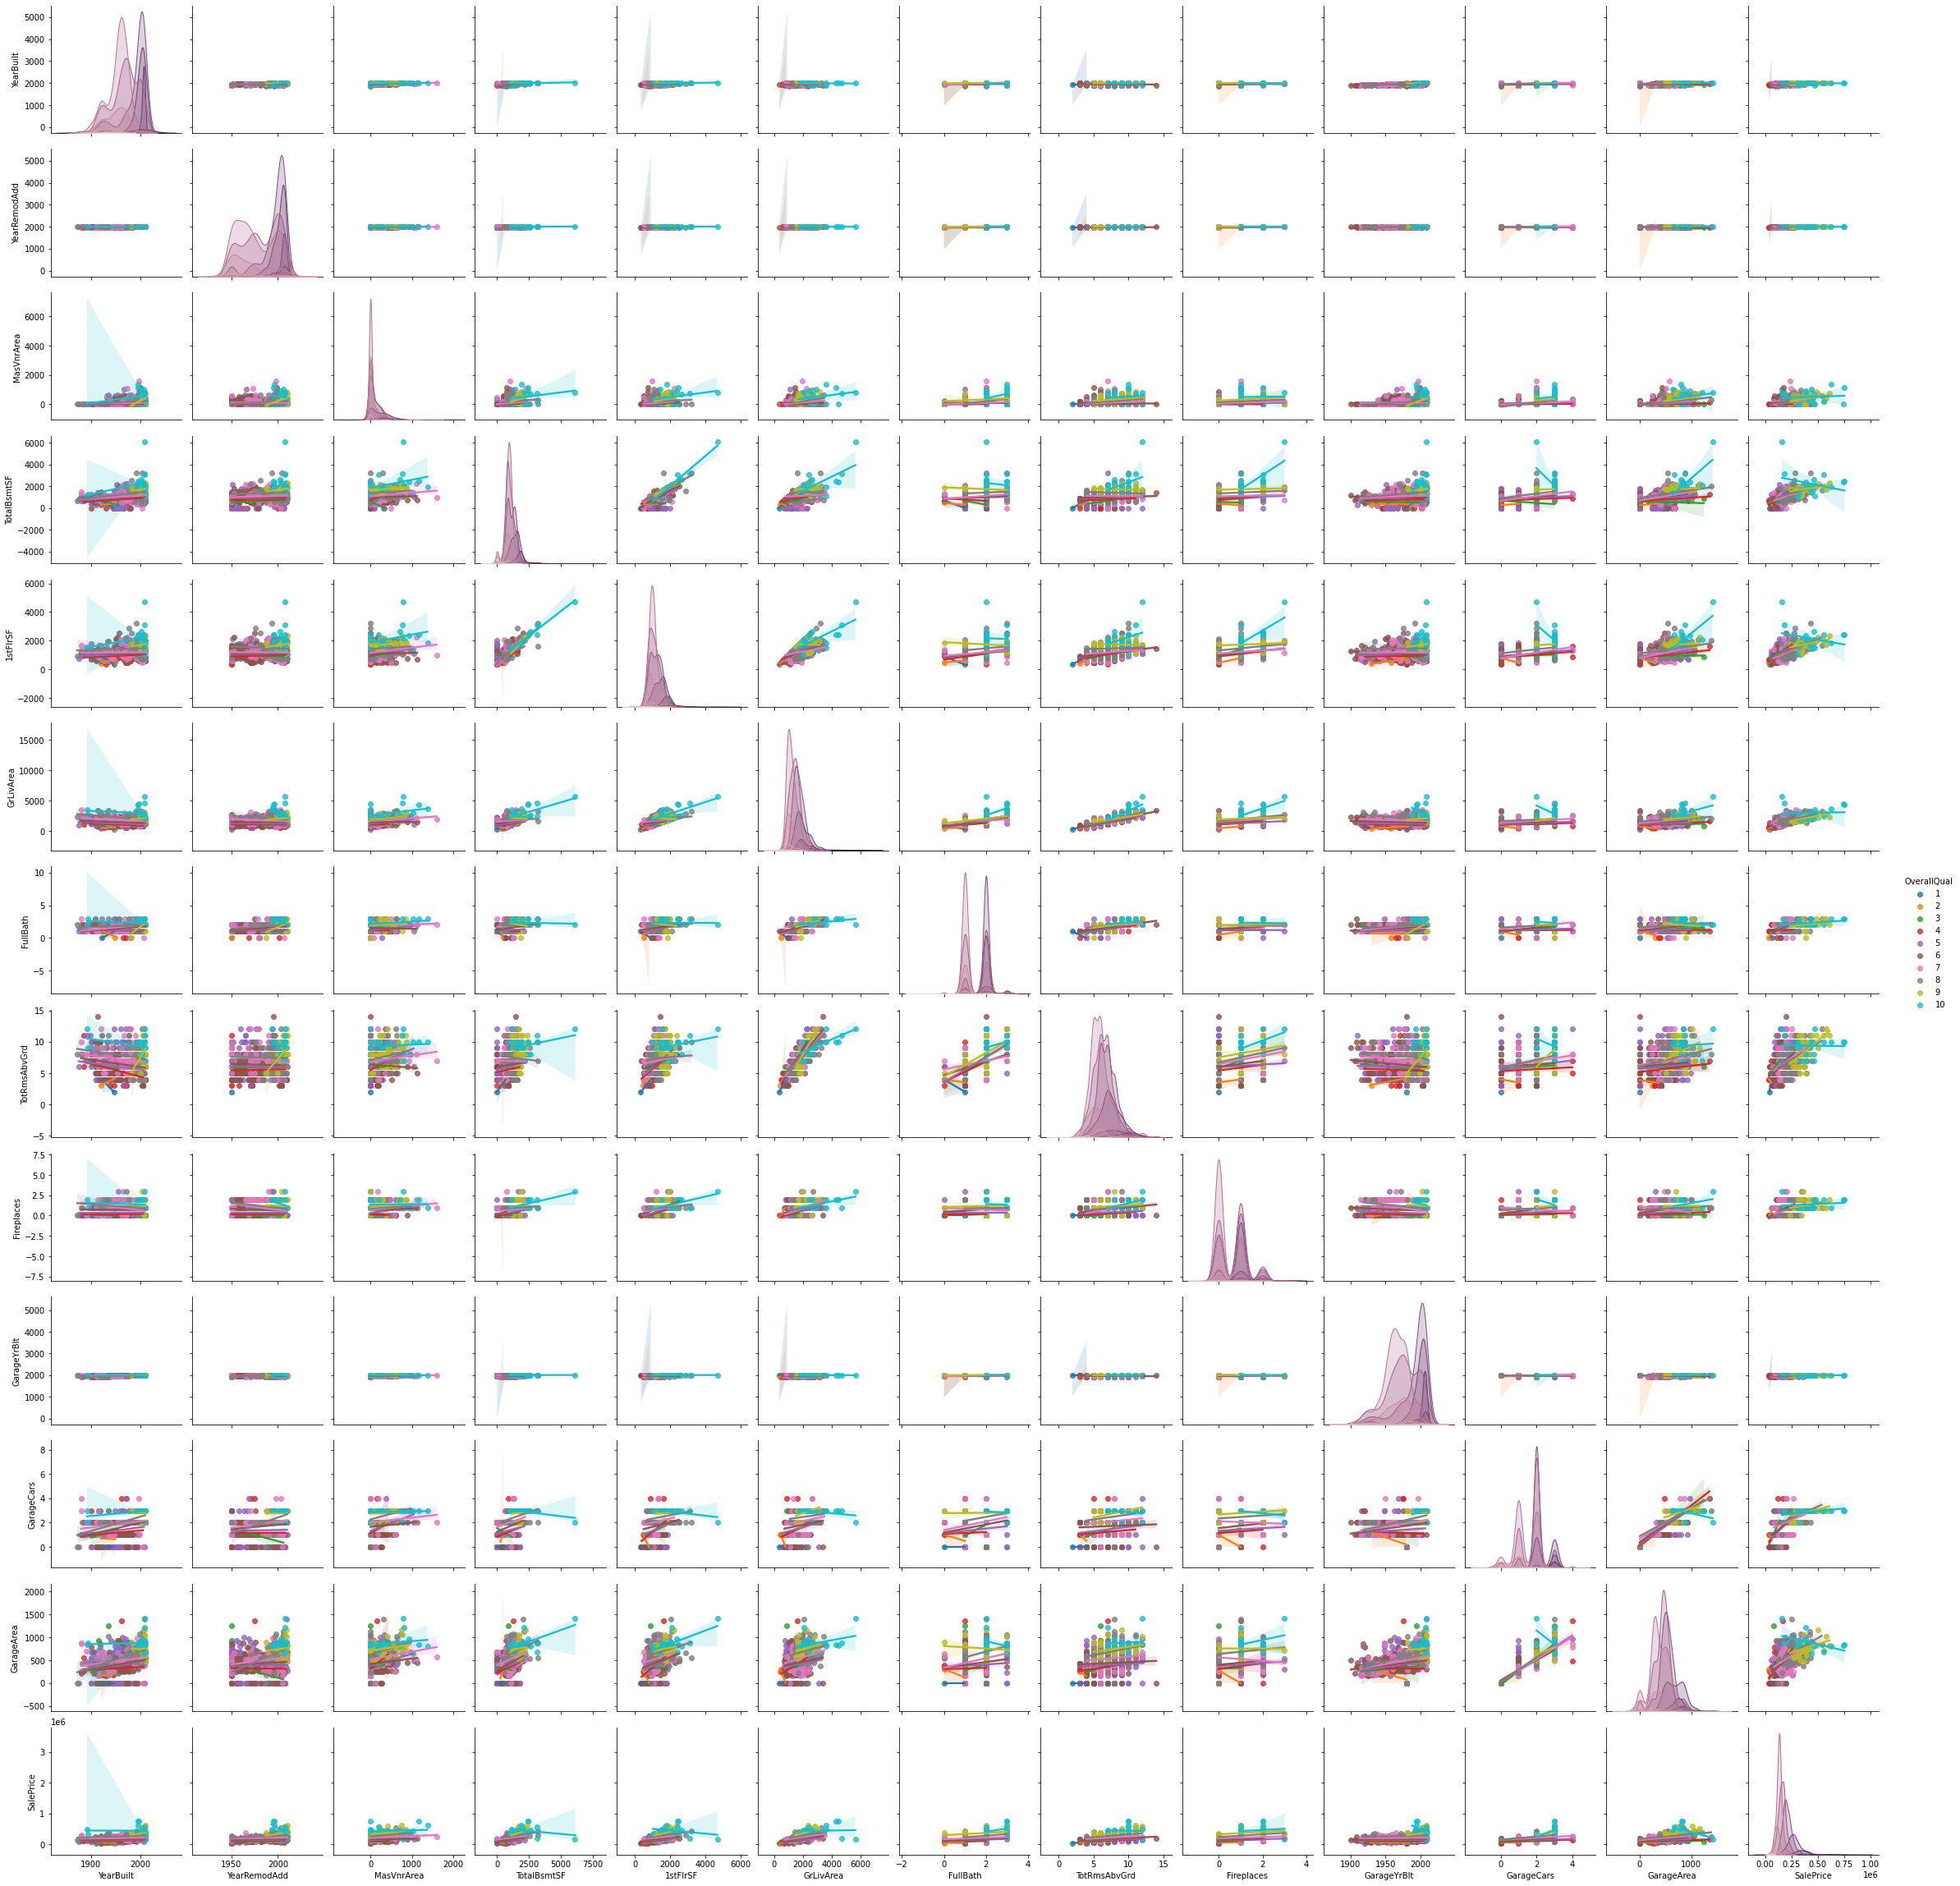

In [13]:
#biểu đồ các cặp biến có độ tương quan cao
plt.figure(figsize=(20,15))
sns.pairplot(data=eda_train_data,diag_kind='kde',hue='OverallQual',kind='reg')
plt.show()

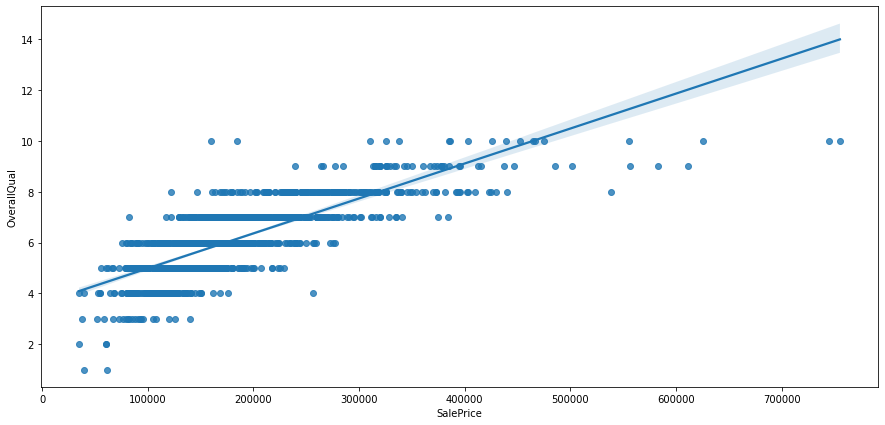

In [14]:
#Độ tương quan cao giữa thuộc tính Overall Quality và SalePrice
plt.figure(figsize=(15,7))
sns.regplot(data=eda_train_data,x='SalePrice',y='OverallQual')
plt.show()

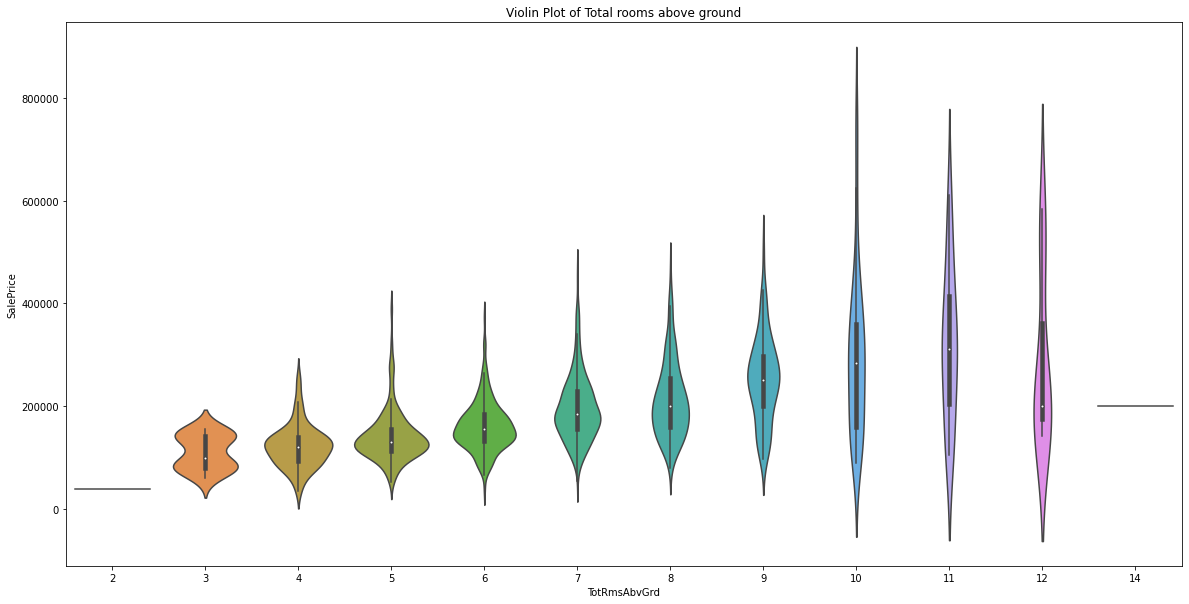

In [15]:
#violin plot of Total rooms above ground
plt.figure(figsize=(20,10))
sns.violinplot(data=eda_train_data,x='TotRmsAbvGrd',y='SalePrice')
plt.title('Violin Plot of Total rooms above ground')
plt.show()

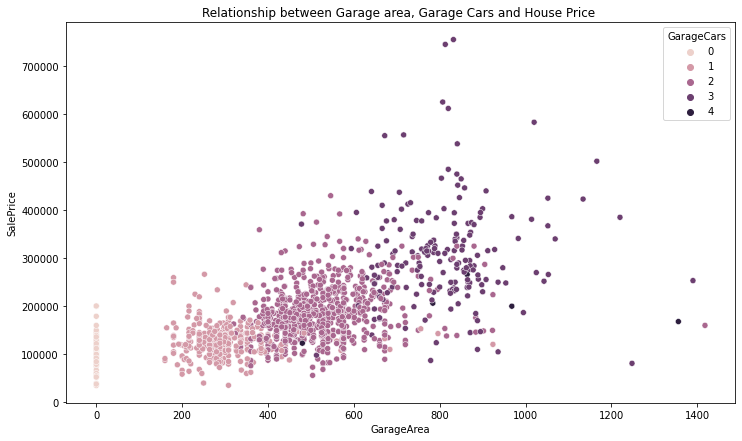

In [16]:
plt.figure(figsize=(12,7))
sns.scatterplot(data=eda_train_data,x='GarageArea',y='SalePrice',hue='GarageCars')
plt.title('Relationship between Garage area, Garage Cars and House Price ')
plt.show()

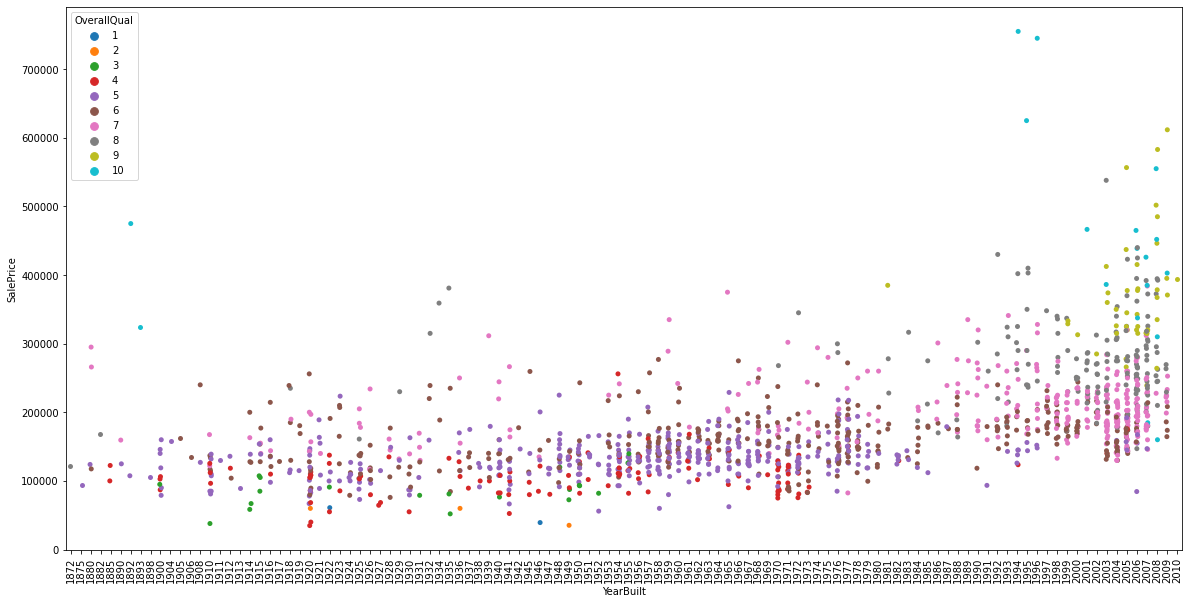

In [17]:
plt.figure(figsize=(20,10))
sns.stripplot(data=eda_train_data,x='YearBuilt',y='SalePrice',hue='OverallQual')
plt.xticks(rotation=90)
plt.show()

In [18]:
#Xác định X_train, y_train, X_test, y_test
X = eda_train_data.drop('SalePrice',axis=1)
y = eda_train_data['SalePrice']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.8)

#Random Forest Regressor

Train dữ liệu đã chia

In [19]:
rfr_model=RandomForestRegressor(n_estimators=200,max_depth=15,criterion='absolute_error')
rfr_model.fit(X_train,y_train)
preds = rfr_model.predict(X_test)

rfr_mape=mean_absolute_percentage_error(y_test,preds)
rfr_r2=r2_score(y_test,preds)
print("Mean Absolute Percentage Error:",rfr_mape)
print("R2 score:", rfr_r2)

Mean Absolute Percentage Error: 0.12808042987035448
R2 score: 0.8105533926773474


Tune các siêu tham số của mô hình Random Forest Regressor

In [20]:
grid_for_rfr = {'n_estimators':[int(x) for x in np.linspace(start = 100, stop = 500, num = 5)],
'max_features': ['auto', 'sqrt'],
'max_depth': [int(x) for x in np.linspace(5, 30, num = 6)],
'min_samples_split': [2, 5, 10, 15, 100],
'min_samples_leaf': [1, 2, 5, 10]
}

In [21]:
random_rfr = RandomizedSearchCV(rfr_model, param_distributions=grid_for_rfr, cv=5, n_iter=10,n_jobs=-1)
random_rfr.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(criterion='absolute_error',
                                                   max_depth=15,
                                                   n_estimators=200),
                   n_jobs=-1,
                   param_distributions={'max_depth': [5, 10, 15, 20, 25, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 15,
                                                              100],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500]})

In [22]:
print("Best estimator:", random_rfr.best_estimator_, "\n")
print("Best score:", random_rfr.best_score_, "\n")
print("Best params:", random_rfr.best_params_, "\n")

Best estimator: RandomForestRegressor(criterion='absolute_error', max_depth=20,
                      max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=5, n_estimators=400) 

Best score: 0.7983694015076017 

Best params: {'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 20} 



#Gradient Boosting Regressor

Train dữ liệu đã chia

In [23]:
gbr_model = GradientBoostingRegressor(n_estimators=700)
gbr_model.fit(X_train,y_train)
gbr_preds = gbr_model.predict(X_test)

gbr_mape=mean_absolute_percentage_error(y_test,gbr_preds)
gbr_r2=r2_score(y_test, gbr_preds)
print("Mean Absolubte Percentage Error:", gbr_mape)
print("R2 score:", gbr_r2)

Mean Absolubte Percentage Error: 0.12697572921190153
R2 score: 0.8197658163201746


Tune các siêu tham số của mô hình GBR với Grid Search

In [24]:
grid_for_gbr = {'n_estimators':[500,1000,2000],'learning_rate':[.001,0.01,.1],'max_depth':[1,2,4],'subsample':[.5,.75,1],'random_state':[1]}
gs_gbr = GridSearchCV(estimator=gbr_model,param_grid=grid_for_gbr,scoring='r2',n_jobs=1,cv=5)
gs_gbr.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(n_estimators=700),
             n_jobs=1,
             param_grid={'learning_rate': [0.001, 0.01, 0.1],
                         'max_depth': [1, 2, 4],
                         'n_estimators': [500, 1000, 2000], 'random_state': [1],
                         'subsample': [0.5, 0.75, 1]},
             scoring='r2')

In [25]:
print("Best estimator:", gs_gbr.best_estimator_, "\n")
print("Best score:", gs_gbr.best_score_, "\n")
print("Best params:", gs_gbr.best_params_, "\n")

Best estimator: GradientBoostingRegressor(learning_rate=0.01, max_depth=4, n_estimators=500,
                          random_state=1, subsample=0.5) 

Best score: 0.8085943746553752 

Best params: {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 500, 'random_state': 1, 'subsample': 0.5} 



#Linear Regression

Train trên dữ liệu đã chia

In [26]:
lr_model = LinearRegression()
lr_model.fit(X_train,y_train)
lr_preds = lr_model.predict(X_test)

lr_mape=mean_absolute_percentage_error(y_test,lr_preds)
lr_r2=r2_score(y_test, lr_preds)
print("Mean Absolubte Percentage Error:", lr_mape)
print("R2 score:", lr_r2)

Mean Absolubte Percentage Error: 0.17270830682143723
R2 score: 0.721449673280945


#XG Boosting Regressor

Train trên dữ liệu đã chia

In [27]:
xbg_model = XGBRegressor(n_estimators=1500, max_depth=10) 
xbg_model.fit(X_train, y_train)
xbg_preds = xbg_model.predict(X_test)

xbg_mape = mean_absolute_percentage_error(y_test, xbg_preds)
xbg_r2 = r2_score(y_test, xbg_preds)
print("Mean Absolubte Percentage Error:", xbg_mape)
print("R2 score:", xbg_r2)

[06:02:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Mean Absolubte Percentage Error: 0.13114140501205246
R2 score: 0.7904950922387287


Tune các siêu tham số của mô hình XG Boosting Regressor với Randomized Search

In [28]:
grid_for_xbg =  {
    'n_estimators': [100, 500, 900, 1100, 1500],
    'max_depth': [2, 3, 5, 10, 15],
    'learning_rate': [0.05,0.1,0.15,0.20],
    'min_child_weight':[1,2,3,4],
    'booster': ['gbtree','gblinear'],
    'base_score': [0.25,0.5,0.75,1]
    }

In [29]:
random_xbg = RandomizedSearchCV(estimator=xbg_model,
            param_distributions= grid_for_xbg,
            cv=5, n_iter=50,
            scoring = 'r2',
            n_jobs = 4,
            verbose = 5, 
            random_state=42)
random_xbg.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[06:03:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(max_depth=10, n_estimators=1500),
                   n_iter=50, n_jobs=4,
                   param_distributions={'base_score': [0.25, 0.5, 0.75, 1],
                                        'booster': ['gbtree', 'gblinear'],
                                        'learning_rate': [0.05, 0.1, 0.15, 0.2],
                                        'max_depth': [2, 3, 5, 10, 15],
                                        'min_child_weight': [1, 2, 3, 4],
                                        'n_estimators': [100, 500, 900, 1100,
                                                         1500]},
                   random_state=42, scoring='r2', verbose=5)

In [30]:
print("Best estimator:", random_xbg.best_estimator_, "\n")
print("Best score:", random_xbg.best_score_, "\n")
print("Best params:",random_xbg.best_params_, "\n")

Best estimator: XGBRegressor(base_score=0.25, max_depth=10, min_child_weight=3) 

Best score: 0.8116251354581557 

Best params: {'n_estimators': 100, 'min_child_weight': 3, 'max_depth': 10, 'learning_rate': 0.1, 'booster': 'gbtree', 'base_score': 0.25} 

